# CNN Sample

This section implements a simple CNN to serve as a better visualization of the permutation test method described in "Permutation-based Hypothesis Testing for Neural Networks."
The model consists of 3 layers: a CNN layer with 2 out channels and a 15x15 kernel, a ReLU layer, and a linear layer.

The training dataset consists of 60000 samples, each sample is a 28x28 image with only 1 color.

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import numpy as np
import math

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

DATA = "./_Data/"
ORIGINAL = "./_Data/parameters/original/"
PERMUTED = "./_Data/parameters/permuted/"
TEST_STAT = "./_Data/perm_test_stats/"

trainset = datasets.MNIST(DATA + 'train', download=True, train=True, transform=transform)
testset = datasets.MNIST(DATA + 'test', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Train and Test

In [2]:
# model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 15)
        self.fc1 = nn.Linear(2 * 14 * 14, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 2*14*14)
        x = self.fc1(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [46]:
# train
for epoch in range(6):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:  
            print('[epoch %d, batch %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

[epoch 1, batch   200] loss: 1.060
[epoch 1, batch   400] loss: 0.440
[epoch 1, batch   600] loss: 0.395
[epoch 1, batch   800] loss: 0.362
[epoch 2, batch   200] loss: 0.311
[epoch 2, batch   400] loss: 0.313
[epoch 2, batch   600] loss: 0.304
[epoch 2, batch   800] loss: 0.292
[epoch 3, batch   200] loss: 0.260
[epoch 3, batch   400] loss: 0.261
[epoch 3, batch   600] loss: 0.264
[epoch 3, batch   800] loss: 0.235
[epoch 4, batch   200] loss: 0.226
[epoch 4, batch   400] loss: 0.228
[epoch 4, batch   600] loss: 0.236
[epoch 4, batch   800] loss: 0.226
[epoch 5, batch   200] loss: 0.222
[epoch 5, batch   400] loss: 0.215
[epoch 5, batch   600] loss: 0.212
[epoch 5, batch   800] loss: 0.207
[epoch 6, batch   200] loss: 0.196
[epoch 6, batch   400] loss: 0.199
[epoch 6, batch   600] loss: 0.192
[epoch 6, batch   800] loss: 0.206


In [47]:
# test
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (
    100 * correct / total))

Accuracy: 95 %


In [24]:
# save parameters
torch.save(model.conv1.weight, ORIGINAL+'conv_w.pt')
torch.save(model.fc1.weight, ORIGINAL+'fc_w.pt')
torch.save(model.conv1.bias, ORIGINAL+'conv_b.pt')
torch.save(model.fc1.bias, ORIGINAL+'fc_b.pt')

# Permutation test

This section implements the association test featured in "Permutation-based Hypothesis Testing for Neural Networks."

Link: https://arxiv.org/pdf/2301.11354

## Functions (to load data and run test)

In [2]:
cpu = torch.device('cpu')
# load parameters and convert to np array
def loadParam(num=None):
    # load parameters (original)
    if num == None:
        d1 = ORIGINAL+'conv_w.pt'
        d2 = ORIGINAL+'fc_w.pt'
        d3 = ORIGINAL+'conv_b.pt'
        d4 = ORIGINAL+'fc_b.pt'
    # load parameters (permuted)
    else:
        d1 = PERMUTED+'conv_w' + str(num)+ '.pt'
        d2 = PERMUTED+'fc_w' + str(num)+ '.pt'
        d3 = PERMUTED+'conv_b' + str(num)+ '.pt'
        d4 = PERMUTED+'fc_b' + str(num)+ '.pt'
    
    conv_w = torch.load(d1, map_location=cpu, weights_only=True).detach().cpu().numpy()
    fc_w = torch.load(d2, map_location=cpu, weights_only=True).detach().cpu().numpy()
    conv_b = torch.load(d3, map_location=cpu, weights_only=True).detach().cpu().numpy()
    fc_b = torch.load(d4, map_location=cpu, weights_only=True).detach().cpu().numpy()
     
    return conv_w, fc_w, conv_b, fc_b

## Partial Derivative Calculation (no acceleration)

`partialDerivative(X, w, b, f, df, types)`

Calculates the partial derivative of a single sample using Chain Rule.

<b> Parameters: </b>

`X`: a single sample from the training data \
`w`: a list containing the weights obtained in layer of the neural network \
`b`: a list containing the biases obtained in layer of the neural network\
&ensp; (For layers that does not have weights/bias, the corresponding element is set to `None`) \
`f`: a list of functions representing each layer of the neural network \
`df`: a list of functions representing the derivatives of each element in `f` \
&ensp; (For matrix reshaping layers, the corresponding element is set to `None`) \
`types`: a list of integers corresponding to the correct way to calculate partial derivative for each layer

| Value          | Corresponding Functions|
| :-----------  | :------------------------- |
| 0 | reshape function  |
| 1    | ReLU / mask |
| 2 | argmax / argmin  |
| 3    | default  |

In [3]:
# calculate partial derivative
def partialDerivative(X, w, b, f, df, types):
    y = f[0](X, w[0], b[0])
    dy = df[0](X, w[0], b[0], y)
    for k in range(1, len(f)):
        y_new = f[k](y, w[k], b[k])
        if types[k] == 0:
            dy = f[k](dy)
        elif types[k] == 1:
            dy = df[k](y, w[k], b[k], y_new) * dy
        elif types[k] == 2:
            dy = df[k](dy, y)
        else:
            dy = df[k](y, w[k], b[k], y_new) @ dy.T
        y = y_new
        
    return dy

### Functions

`f(x, w, b)` 

Function used in each layer

<b> Parameters: </b>
`x`: input \
`w`: weight \
`b`: bias 

In [4]:
# 2D convolution
def conv2D(X, w, b):
    c, _, m, n = w.shape
    new_shape = tuple(np.subtract(X.shape, (m,n)) + 1) + (m,n)
    sub_mat = np.lib.stride_tricks.as_strided(X, new_shape, X.strides + X.strides)
    x_new = np.zeros((c, new_shape[0], new_shape[1]))
    for i in range(c):
        x_new[i] = np.sum((w[i] * sub_mat), axis=(2,3)) + b[i]
    return x_new

# ReLU
def relu(X, w=None, b=None):
    return np.maximum(X, 0)

def linear(X, w, b):
    return (w @ X.T).flatten() + b

# reshape function
def reshape(x, w=None, b=None):
    return np.reshape(x, (-1,2*14*14))


### Derivatives

`df(x, w, b, y)` 

Partial derivative of a layer

<b> Parameters: </b>
`x`: input \
`w`: weight \
`b`: bias \
`y`: output `f(x)`

*exception: derivative of np.max*

In [5]:
# derivatice of 2D convolution layer
def dconv(X, w, b, y):
    kernel_shape = w.shape[2:]
    y_shape = np.subtract(X.shape, w.shape[2:]) + 1
    sub_mat = np.zeros(w.shape[:1] + tuple(np.add((y_shape-1)*2, kernel_shape)))
    sub_mat[:,y_shape[0]-1 : X.shape[0], y_shape[1]-1 : X.shape[1]] = np.reshape(w, tuple([w.shape[0]]) + w.shape[2:])
    grad = np.lib.stride_tricks.as_strided(sub_mat, X.shape + w.shape[:1] + tuple(y_shape), sub_mat.strides[1:] + sub_mat.strides)
    grad = np.flip(grad, axis=(3,4))
    
    return grad

# derivative of ReLU layer
def drelu(x, w, b, y):
    return 1. * (x > 0)

# derivative of linear layer
def dlinear(x, w, b, y):
    return w

# derivative of max function
# dy: partial derivative of the previous iteration
# y: output of the previous iteration
def dmax(dy, y):
    maximum = y[0]
    ind = 0
    for k in range(1, len(y)):
        if y[k] > maximum:
            maximum = y[k]
            ind = k
    return dy[ind]

### Calculate test statistics

In [6]:
def calculateT(trainset_np, weights, bias, functions, derivatives, types):
    T = np.zeros(28*28)

    for data in trainset_np:
        pd = partialDerivative(data, weights, bias, functions, derivatives, types)
        T += np.square(pd)
        
    return T / len(trainset_np)

## Partial Derivatives (CuPy)

### Implementation

In [7]:
import cupy as cp

In [8]:
# 2D convolution
def conv2D_cp(X, w, b):
    c, _, m, n = w.shape
    new_shape = tuple(np.subtract(X.shape, (0,m-1,n-1))) + (m,n)
    sub_mat = cp.lib.stride_tricks.as_strided(X, new_shape, X.strides + X[0].strides)
    x_new = cp.zeros((X.shape[0], c, new_shape[1], new_shape[2]))
    for i in range(c):
        x_new[:,i] = cp.sum((w[i] * sub_mat), axis=(3,4)) + b[i]
    return x_new

# ReLU
def relu_cp(X):
    return cp.maximum(X, 0)

def linear_cp(X, w, b):
    return (w @ X.T).T + b

def reshape_cp(x):
    return cp.reshape(x, x.shape[0:-3] + tuple([2*14*14]))

In [9]:
# derivatice of 2D convolution layer
def dconv_cp(X, w):
    kernel_shape = w.shape[2:]
    y_shape = np.subtract(X[0].shape, w.shape[2:]) + 1
    sub_mat = cp.zeros(w.shape[:1] + tuple(np.add((y_shape-1)*2, kernel_shape)))
    sub_mat[:, y_shape[0]-1 : X[0].shape[0], y_shape[1]-1 : X[0].shape[1]] = cp.reshape(w, tuple([w.shape[0]]) + w.shape[2:])
    grad = cp.lib.stride_tricks.as_strided(sub_mat, X[0].shape + w.shape[:1] + tuple(y_shape), sub_mat.strides[1:] + sub_mat.strides)
    grad = cp.flip(grad, axis=(3,4))
    
    return grad.reshape((-1,) + grad.shape[2:])

# derivative of ReLU layer
def drelu_cp(x):
    return 1. * (x > 0)

# derivative of linear layer
def dlinear_cp(x, w):
    return w

# derivative of max function
# dy: partial derivative of the previous iteration
# y: output of the previous iteration
def dmax_cp(dy, y):
    ind = cp.expand_dims(cp.repeat(cp.argmax(y, axis=1), dy.shape[0] // y.shape[0]), axis=1)
    return cp.take_along_axis(dy, ind, axis=-1)

### Test on Simple CNN

In [11]:
def calculateT_cp(batch_size):
    # get parameters
    conv_w, fc_w, conv_b, fc_b = loadParam()

    conv_w = cp.asarray(conv_w)
    fc_w = cp.asarray(fc_w)
    conv_b = cp.asarray(conv_b)
    fc_b = cp.asarray(fc_b)
    X = cp.asarray(trainset.data.numpy())
    
    # cache for storing reusable partial derivatives
    cache = {}
    
    # initialize test statistics
    T = cp.zeros(math.prod(X[0].shape))
    
    # for each batch, calculate the partial derivatices and test statistics
    for i in range(0, X.shape[0] - 1, batch_size):
        pd = pd_batch(cache, X[i:min(i+batch_size, X.shape[0])], conv_w, fc_w, conv_b, fc_b)
        T += cp.sum(cp.square(pd), axis=0)
    
    return T / len(trainset)
        
# calculate the partial derivatives for a batch of input images  
def pd_batch(cache, X, conv_w, fc_w, conv_b, fc_b):
    # convolution layer
    y_0 = conv2D_cp(X, conv_w, conv_b)
    if 0 in cache:
        dy_0 = cache[0]
    else:
        dy_0 = dconv_cp(X, conv_w)
        cache[0] = dy_0
    
    # relu layer
    y_1 = relu_cp(y_0)
    dy_1 = drelu_cp(y_0)
    dy_1 = cp.tile(dy_1[:, cp.newaxis, :, :, :], (1, dy_0.shape[0], 1, 1, 1)) * dy_0
    
    # reshape
    y_2 = reshape_cp(y_1)
    dy_2 = reshape_cp(dy_1)
    dy_2 = dy_2.reshape(-1, dy_2.shape[-1])
    
    # linear layer
    y_3 = linear_cp(y_2, fc_w, fc_b)
    dy_3 = dlinear_cp(y_2, fc_w)
    dy_3 = dy_3 @ dy_2.T
    
    # max layer
    dy_4 = dmax_cp(dy_3.T, y_3)
    
    return dy_4.reshape(X.shape[0], -1)

In [17]:
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

GPU Name: NVIDIA GeForce RTX 2080 Ti


In [12]:
# clear GPU memory
cp._default_memory_pool.free_all_blocks()

In [14]:
# calculate test statistics
start_time = time.perf_counter()
T = calculateT_cp(1500)
end_time = time.perf_counter()
runtime = end_time - start_time
print(f"Full test statistics calculation runtime (cupy): {runtime:.4f} seconds")

Full test statistics calculation runtime (cupy): 1.1864 seconds


Text(0.5, 1.0, 'Test Statistics (Original)')

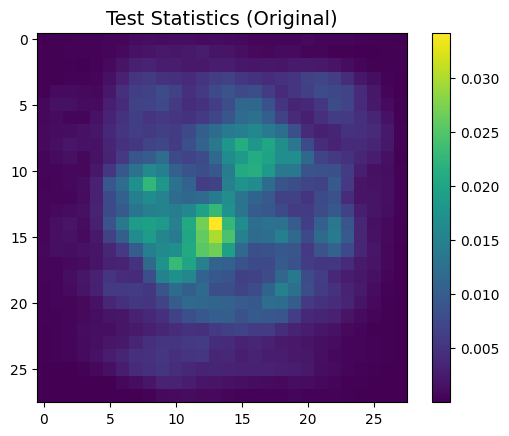

In [15]:
# graph test statistics (verify result)
imgplot = plt.imshow(cp.asnumpy(T).reshape((28,28)))
plt.colorbar(imgplot)
plt.title("Test Statistics (Original)", fontsize=14, loc='center')

### Performance Comparison (CuPy vs. NumPy partial derivative calculation)

Simply replacing numpy functions with cupy functions reduces the execution time by ~60%.
Breakdown: First time running the CuPy version of partial derivative calculation is slower due to one-time overhead. Calculation for the rest of the datapoints will be faster than the numpy version.

Reference: https://docs.cupy.dev/en/stable/user_guide/performance.html

## Permute

Permute `y` 100 times and retrain the model using the original `X` and permuted `y`

In [ ]:
for i in range(100):
    print("permutation", i)
    model = CNN()
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # train
    for epoch in range(6):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            ind = torch.randperm(labels.shape[0])
            labels = labels[ind]
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    # save parameters
    torch.save(model.conv1.weight, PERMUTED+'conv_w.pt')
    torch.save(model.fc1.weight, PERMUTED+'fc_w.pt')
    torch.save(model.conv1.bias, PERMUTED+'conv_b.pt')
    torch.save(model.fc1.bias, PERMUTED+'fc_b.pt')

## Run Test

In [11]:
# load parameters (Original)
conv_w, fc_w, conv_b, fc_b = loadParam()

# parameter initialization
weights = [conv_w, None, None, fc_w, None]
bias = [conv_b, None, None, fc_b, None]
functions = [conv2D, relu, reshape, linear, np.max]
derivatives = [dconv, drelu, None, dlinear, dmax]
types = [1,1,0,3,2]
trainset_np = trainset.data.numpy()

# calculate test statistics
start_time = time.perf_counter()
T_orig = calculateT(trainset_np, weights, bias, functions, derivatives, types)
end_time = time.perf_counter()
runtime = end_time - start_time
print(f"Runtime: {runtime:.4f} seconds")

Runtime: 176.4417 seconds


In [51]:
# load parameters (Permuted)
conv_w, fc_w, conv_b, fc_b = loadParam(0)

# parameter initialization
weights = [conv_w, None, None, fc_w, None]
bias = [conv_b, None, None, fc_b, None]
functions = [conv2D, relu, reshape, linear, np.max]
derivatives = [dconv, drelu, None, dlinear, dmax]
types = [1,1,0,3,2]
trainset_np = trainset.data.numpy()

# calculate test statistics
start_time = time.perf_counter()
T_perm = calculateT(trainset_np, weights, bias, functions, derivatives, types)
end_time = time.perf_counter()
runtime = end_time - start_time
print(f"Runtime: {runtime:.4f} seconds")

Runtime: 175.9867 seconds


## Test Statistic Visualization and Comparison

Text(0.5, 1.0, 'Test Statistics (Original)')

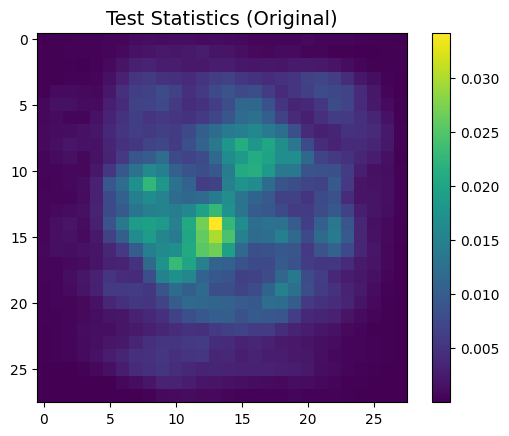

In [60]:
imgplot = plt.imshow(T_orig.reshape((28,28)))
plt.colorbar(imgplot)
plt.title("Test Statistics (Original)", fontsize=14, loc='center')

Text(0.5, 1.0, 'Test Statistics (Permuted)')

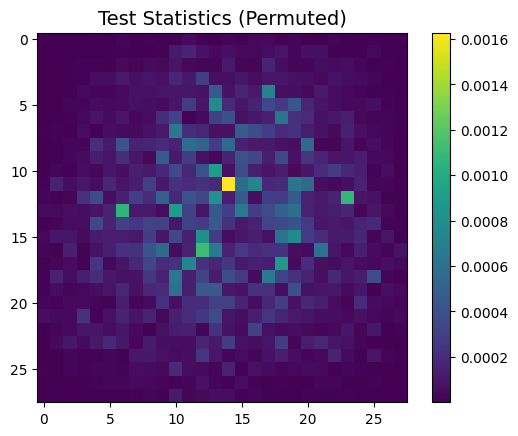

In [61]:
imgplot = plt.imshow(T_perm.reshape((28,28)))
plt.colorbar(imgplot)
plt.title("Test Statistics (Permuted)", fontsize=14, loc='center')

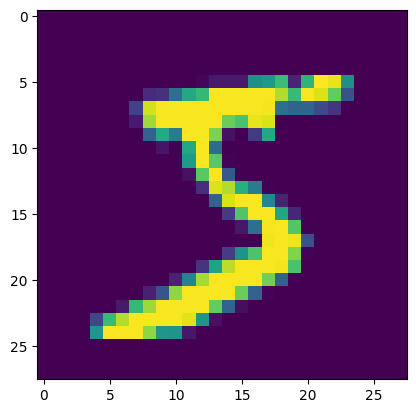

In [62]:
# image of a single data point (for result validation)
plt.imshow(trainset_np[0])

## P-value Visualization

In [13]:
def read_stats(num=None):
    # load parameters (original)
    if num == None:
        d = TEST_STAT+'stats.txt'
    # load parameters (permuted)
    else:
        d = TEST_STAT+'stats_' + str(num)+ '.txt'
    
    return np.loadtxt(d, delimiter=',')

# find p-value of each SNP
def p_values(orig, perm):
    p_vals = []

    for i in range(len(orig)):
        p_vals.append(sum(stat > orig[i] for stat in perm[:,i]) / len(perm))

    return p_vals

In [26]:
orig = read_stats()
orig = orig / np.sum(orig)
perm = []
for i in range(100):
    d = read_stats(i)
    perm.append(d / np.sum(d))
perm = np.array(perm)

In [32]:
p_vals = p_values(orig, perm)
p_vals = np.array(p_vals)

In [ ]:
imgplot = plt.imshow(p_vals.reshape((28,28)))
plt.colorbar(imgplot)
plt.title("P-values (with normalization)", fontsize=14, loc='center')

In [78]:
p_vals1 = p_vals * (p_vals < 0.2) + (p_vals == 0.0)
p_vals1 += (p_vals1 == 0.0)

Text(0.5, 1.0, 'P-values (threshold=0.2)')

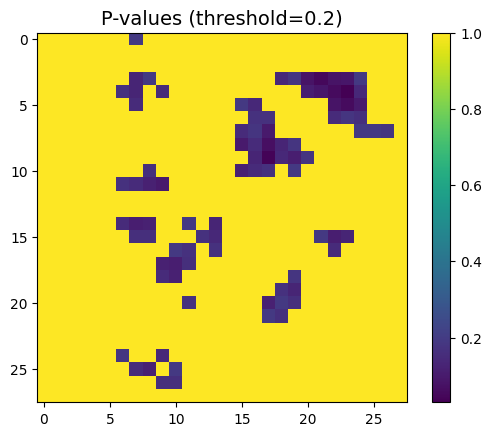

In [80]:
imgplot = plt.imshow(p_vals1.reshape((28,28)))
plt.colorbar(imgplot)
plt.title("P-values (threshold=0.2)", fontsize=14, loc='center')